# 2. Model Train

## Model Xception

### Import libraries

In [1]:
import os
import timeit

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import (accuracy_score, balanced_accuracy_score,
                             classification_report, confusion_matrix)
from sklearn.utils.class_weight import compute_class_weight

In [2]:
np.random.seed(12049)

In [3]:
def get_plot_loss_acc(model, model_name):
    fig = plt.figure()
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["loss"])
    plt.plot(model.history.history["val_loss"])
    plt.title(f"{model_name} \n\n model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper right")

    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["accuracy"])
    plt.plot(model.history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="lower right")

    plt.tight_layout()


def compute_confusion_matrix(
    ytrue, ypred, class_names, model_name
):
    cm = confusion_matrix(
        y_true=ytrue.labels,
        y_pred=np.argmax(ypred, axis=1),
    )

    cmn = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cmn,
        annot=True,
        fmt=".2f",
        cmap="Purples",
        xticklabels=class_names,
        yticklabels=class_names,
    )
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show(block=False)


def get_evaluate(data, name, model):
    score_model = model.evaluate(data, verbose=1)
    print(f"{name} loss: {score_model[0]:.2f}")
    print(f"{name} accuracy: {score_model[1]:.2f}")


def get_predict(data, model):
    predict_model = model.predict(data)
    return predict_model


def get_metrics(y_test, y_pred, model_name):
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)

    print(f"Accuracy Score - {model_name}: {acc:.2f}")
    print(f"Balanced Accuracy Score - {model_name}: {bal_acc:.2f}")
    print("\n")

    print(classification_report(y_test, y_pred))

### Load data

In [4]:
base_dir = r"C:\Users\jagad\Desktop\junior\all files\dataset"
train_path = os.path.join(base_dir, 'train')
valid_path = os.path.join(base_dir, 'val')
test_path = os.path.join(base_dir, 'test')

### Definitions

In [5]:
# Specify the path and name of the file
file_path = r'C:\Users\jagad\Desktop\junior\all files\output.txt'


# Open the file in read mode and read the contents into a list
with open(file_path, 'r') as file:
    content_list = file.readlines()

# Remove newline characters from each element
class_names = [line.strip() for line in content_list]

print(class_names)



['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [6]:
model_name = "Xception"
# class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
target_size = (224, 224)
epochs = 100
batch_size = 256
img_shape = (224, 224, 3)

# Save model
save_model_ft = os.path.join('models', f'model_{model_name}_ft.hdf5')

### Image data generator

In [7]:
aug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    width_shift_range=[-50, 0, 50, 30, -30],
    zoom_range=0.1,
    fill_mode="nearest",
)

noaug_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input,
)

In [8]:
train_generator = aug_datagen.flow_from_directory(
    train_path, class_mode="categorical", target_size=target_size, shuffle=True
)

valid_generator = noaug_datagen.flow_from_directory(
    valid_path,
    class_mode="categorical",
    target_size=target_size,
    shuffle=False,
)

Found 1411 images belonging to 9 classes.
Found 475 images belonging to 9 classes.


In [9]:
y_train = train_generator.labels
y_val = valid_generator.labels

### Weight data

In [10]:
unique, counts = np.unique(y_train, return_counts=True)
print("Train: ", dict(zip(unique, counts)))

class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(y_train), y=y_train
)
train_class_weights = dict(enumerate(class_weights))
print(train_class_weights)

Train:  {0: 78, 1: 235, 2: 66, 3: 272, 4: 223, 5: 286, 6: 48, 7: 118, 8: 85}
{0: 2.00997150997151, 1: 0.6671394799054373, 2: 2.3754208754208754, 3: 0.5763888888888888, 4: 0.7030393622321873, 5: 0.5481740481740481, 6: 3.2662037037037037, 7: 1.3286252354048964, 8: 1.8444444444444446}


### Train data

In [11]:
classes = np.unique(y_train)

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss', min_delta=0.01, patience=8,
            restore_best_weights=True
        )
plateau = tf.keras.callbacks.ReduceLROnPlateau(
                monitor='loss', factor=0.1, min_delta=0.01, 
                min_lr=1e-10, patience=4, mode='auto'
            )

In [12]:
model = tf.keras.applications.xception.Xception(
    input_shape=(img_shape),
    include_top=False,
    weights="imagenet",
)

### Fine-tuning

In [ ]:
for layer in model.layers:
    layer.trainable = True

model_ft = tf.keras.models.Sequential(
    [
        model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(len(class_names), activation="softmax"),
    ]
)

model_ft.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 9)                 18441     
                                                                 
Total params: 20,879,921
Trainable params: 20,825,393
Non-trainable params: 54,528
_________________________________________________________________


In [ ]:
model_ft.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

start_ft = timeit.default_timer()

history = model_ft.fit(
    train_generator,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early, plateau],
    validation_data=valid_generator,
    class_weight=train_class_weights,
    verbose=1,
)

stop_ft = timeit.default_timer()

Epoch 1/100
45/45 [==============================] - 447s 10s/step - loss: 1.6917 - accuracy: 0.3366 - val_loss: 3.8569 - val_accuracy: 0.3032 - lr: 0.0010
Epoch 2/100
45/45 [==============================] - 423s 9s/step - loss: 1.2808 - accuracy: 0.4819 - val_loss: 2.7234 - val_accuracy: 0.4063 - lr: 0.0010
Epoch 3/100
45/45 [==============================] - 415s 9s/step - loss: 1.1282 - accuracy: 0.5514 - val_loss: 2.3669 - val_accuracy: 0.4568 - lr: 0.0010
Epoch 4/100
45/45 [==============================] - 407s 9s/step - loss: 0.9448 - accuracy: 0.5847 - val_loss: 2.3928 - val_accuracy: 0.4274 - lr: 0.0010
Epoch 5/100
45/45 [==============================] - 402s 9s/step - loss: 0.9233 - accuracy: 0.5960 - val_loss: 3.8350 - val_accuracy: 0.2989 - lr: 0.0010
Epoch 6/100
45/45 [==============================] - 399s 9s/step - loss: 0.9778 - accuracy: 0.5974 - val_loss: 2.4921 - val_accuracy: 0.3705 - lr: 0.0010
Epoch 7/100
45/45 [==============================] - 399s 9s/step - l

In [15]:
model_ft.save(save_model_ft)

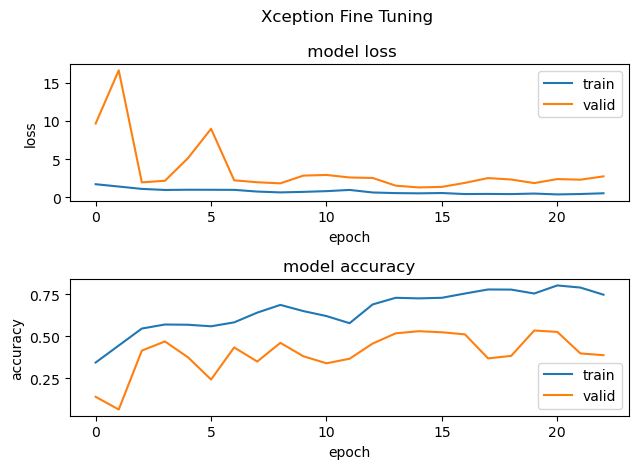

In [16]:
get_plot_loss_acc(model_ft, f"{model_name} Fine Tuning")

In [17]:
get_evaluate(valid_generator, "Valid", model_ft)

15/15 [==============================] - 35s 2s/step - loss: 1.3138 - accuracy: 0.5305
Valid loss: 1.31
Valid accuracy: 0.53


In [18]:
predict_model_ft = get_predict(valid_generator, model_ft)

get_metrics(
    valid_generator.labels,
    y_pred=np.argmax(predict_model_ft, axis=1),
    model_name=model_name,
)

15/15 [==============================] - 36s 2s/step
Accuracy Score - Xception: 0.53
Balanced Accuracy Score - Xception: 0.55


              precision    recall  f1-score   support

           0       0.34      0.92      0.50        26
           1       0.70      0.51      0.59        79
           2       0.90      0.39      0.55        23
           3       0.54      0.49      0.51        91
           4       0.46      0.48      0.47        75
           5       0.74      0.51      0.60        96
           6       0.11      0.25      0.15        16
           7       0.53      0.40      0.46        40
           8       0.67      1.00      0.81        29

    accuracy                           0.53       475
   macro avg       0.56      0.55      0.52       475
weighted avg       0.59      0.53      0.54       475



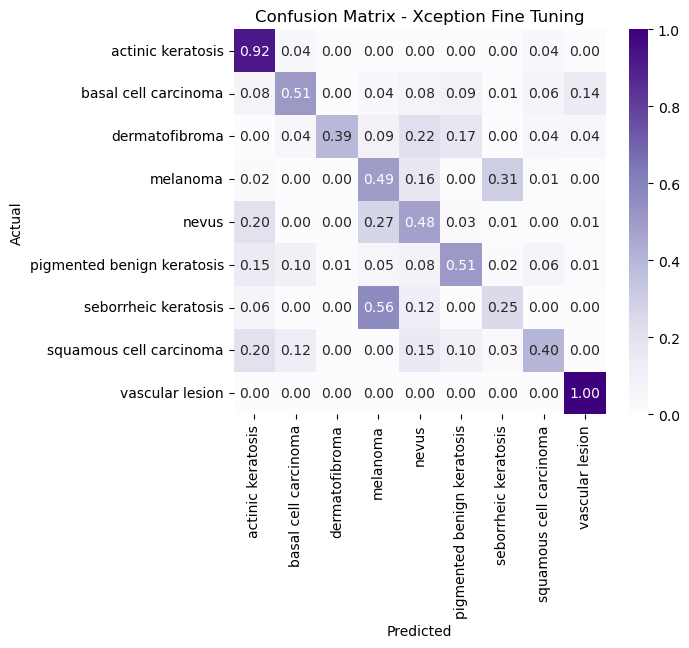

In [19]:
compute_confusion_matrix(
    valid_generator, predict_model_ft, class_names, f"{model_name} Fine Tuning"
)